In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)
print(gpu)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
tqdm.pandas()

from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam,  RMSprop, Nadam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, LSTM, GRU, Embedding,\
    GlobalAveragePooling1D, BatchNormalization, LeakyReLU, Dropout, GlobalMaxPooling1D, ReLU, \
    Bidirectional 

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
# from xgboost import XGBClassifier


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train_data = pd.read_csv('../Dataset/train.csv', engine='python', encoding='utf-8')
train_data

,Id,Title,Body,Tags,CreationDate,Y
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ
...,...,...,...,...,...,...
44995,60461435,Convert List<String> to string C# - asp.net - ...,<p>I am new to this and I am asking for help t...,<c#><asp.net><sql-server>,2020-02-29 02:22:18,LQ_CLOSE
44996,60461754,Does Python execute code from the top or botto...,<p>I am working on learning Python and was won...,<python>,2020-02-29 03:33:59,LQ_CLOSE
44997,60462001,how to change payment date in Azure?,<p>It looks like it costs 8 days per month in ...,<azure><billing>,2020-02-29 04:34:16,LQ_CLOSE
44998,60465318,how to implement fill in the blank in Swift,"<p>""I _____ any questions.""</p>\n\n<p>I want t...",<ios><swift>,2020-02-29 12:50:43,LQ_CLOSE


In [3]:
valid_data = pd.read_csv('../Dataset/valid.csv', engine='python', encoding='utf-8')
valid_data

,Id,Title,Body,Tags,CreationDate,Y
0,34552974,How to get all the child records from differen...,I am having 4 different tables like \r\nselect...,<sql><sql-server>,2016-01-01 01:44:52,LQ_EDIT
1,34554721,Retrieve all except some data of the another t...,I have two table m_master and tbl_appointment\...,<php><mysql><sql><codeigniter><mysqli>,2016-01-01 08:43:50,LQ_EDIT
2,34555135,Pandas: read_html,<p>I'm trying to extract US states from wiki U...,<python><pandas>,2016-01-01 09:55:22,HQ
3,34555448,Reader Always gimme NULL,"I'm so new to C#, I wanna make an application ...",<sql-server><c#-4.0>,2016-01-01 10:43:45,LQ_EDIT
4,34555752,php rearrange array elements based on condition,basically i have this array:\r\n\r\n array(...,<php>,2016-01-01 11:34:09,LQ_EDIT
...,...,...,...,...,...,...
14995,60465681,How can I align two flex boxes to follow each ...,"<p>I have a menu, and I'd like the div.right-c...",<html><css><flexbox>,2020-02-29 13:32:56,LQ_CLOSE
14996,60467932,C++ The correct way to multiply an integer and...,<p>I try to multiply an integer by a double bu...,<c++>,2020-02-29 17:46:41,LQ_CLOSE
14997,60468378,WHY DJANGO IS SHOWING ME THIS ERROR WHEN I TRY...,*URLS.PY*\r\n //URLS.PY FILE\r\n fro...,<django><django-views><django-templates>,2020-02-29 18:35:39,LQ_EDIT
14998,60469392,PHP - getting the content of php page,<p>I have a controller inside which a server i...,<javascript><php><html>,2020-02-29 20:32:14,LQ_CLOSE


In [4]:
data = pd.concat([train_data, valid_data])
data = data.drop(columns = ['Id', 'CreationDate'])
data

,Title,Body,Tags,Y
0,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,LQ_CLOSE
1,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,HQ
2,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,HQ
3,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,HQ
4,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,HQ
...,...,...,...,...
14995,How can I align two flex boxes to follow each ...,"<p>I have a menu, and I'd like the div.right-c...",<html><css><flexbox>,LQ_CLOSE
14996,C++ The correct way to multiply an integer and...,<p>I try to multiply an integer by a double bu...,<c++>,LQ_CLOSE
14997,WHY DJANGO IS SHOWING ME THIS ERROR WHEN I TRY...,*URLS.PY*\r\n //URLS.PY FILE\r\n fro...,<django><django-views><django-templates>,LQ_EDIT
14998,PHP - getting the content of php page,<p>I have a controller inside which a server i...,<javascript><php><html>,LQ_CLOSE


In [5]:
data['label'] = data['Y'].map({'HQ' : 0, 'LQ_EDIT' : 1, 'LQ_CLOSE' : 2})
data

,Title,Body,Tags,Y,label
0,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,LQ_CLOSE,2
1,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,HQ,0
2,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,HQ,0
3,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,HQ,0
4,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,HQ,0
...,...,...,...,...,...
14995,How can I align two flex boxes to follow each ...,"<p>I have a menu, and I'd like the div.right-c...",<html><css><flexbox>,LQ_CLOSE,2
14996,C++ The correct way to multiply an integer and...,<p>I try to multiply an integer by a double bu...,<c++>,LQ_CLOSE,2
14997,WHY DJANGO IS SHOWING ME THIS ERROR WHEN I TRY...,*URLS.PY*\r\n //URLS.PY FILE\r\n fro...,<django><django-views><django-templates>,LQ_EDIT,1
14998,PHP - getting the content of php page,<p>I have a controller inside which a server i...,<javascript><php><html>,LQ_CLOSE,2


In [6]:
def clean_text_tags(text):
    text = re.sub("<|>", " ", text)
    return text

In [7]:
data['Tags'] = data['Tags'].progress_apply(clean_text_tags)
data

  0%|          | 0/60000 [00:00<?, ?it/s]

,Title,Body,Tags,Y,label
0,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,java repeat,LQ_CLOSE,2
1,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,java optional,HQ,0
2,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,javascript image overlay react-native opa...,HQ,0
3,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",swift operators whitespace ternary-operato...,HQ,0
4,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,android material-design floating-action-but...,HQ,0
...,...,...,...,...,...
14995,How can I align two flex boxes to follow each ...,"<p>I have a menu, and I'd like the div.right-c...",html css flexbox,LQ_CLOSE,2
14996,C++ The correct way to multiply an integer and...,<p>I try to multiply an integer by a double bu...,c++,LQ_CLOSE,2
14997,WHY DJANGO IS SHOWING ME THIS ERROR WHEN I TRY...,*URLS.PY*\r\n //URLS.PY FILE\r\n fro...,django django-views django-templates,LQ_EDIT,1
14998,PHP - getting the content of php page,<p>I have a controller inside which a server i...,javascript php html,LQ_CLOSE,2


In [8]:
data['combined_text'] = data['Title'] + ' ' + data['Body'] + ' ' + data['Tags']
# data['combined_text'] = data['Title'] + ' ' + data['Body']
# data['combined_text'] = data['Body']
data

,Title,Body,Tags,Y,label,combined_text
0,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,java repeat,LQ_CLOSE,2,Java: Repeat Task Every Random Seconds <p>I'm ...
1,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,java optional,HQ,0,Why are Java Optionals immutable? <p>I'd like ...
2,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,javascript image overlay react-native opa...,HQ,0,Text Overlay Image with Darkened Opacity React...
3,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",swift operators whitespace ternary-operato...,HQ,0,Why ternary operator in swift is so picky? <p>...
4,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,android material-design floating-action-but...,HQ,0,hide/show fab with scale animation <p>I'm usin...
...,...,...,...,...,...,...
14995,How can I align two flex boxes to follow each ...,"<p>I have a menu, and I'd like the div.right-c...",html css flexbox,LQ_CLOSE,2,How can I align two flex boxes to follow each ...
14996,C++ The correct way to multiply an integer and...,<p>I try to multiply an integer by a double bu...,c++,LQ_CLOSE,2,C++ The correct way to multiply an integer and...
14997,WHY DJANGO IS SHOWING ME THIS ERROR WHEN I TRY...,*URLS.PY*\r\n //URLS.PY FILE\r\n fro...,django django-views django-templates,LQ_EDIT,1,WHY DJANGO IS SHOWING ME THIS ERROR WHEN I TRY...
14998,PHP - getting the content of php page,<p>I have a controller inside which a server i...,javascript php html,LQ_CLOSE,2,PHP - getting the content of php page <p>I hav...


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60000 entries, 0 to 14999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Title          60000 non-null  object
 1   Body           60000 non-null  object
 2   Tags           60000 non-null  object
 3   Y              60000 non-null  object
 4   label          60000 non-null  int64 
 5   combined_text  60000 non-null  object
dtypes: int64(1), object(5)
memory usage: 3.2+ MB


[Text(0, 0, '20000'), Text(0, 0, '20000'), Text(0, 0, '20000')]

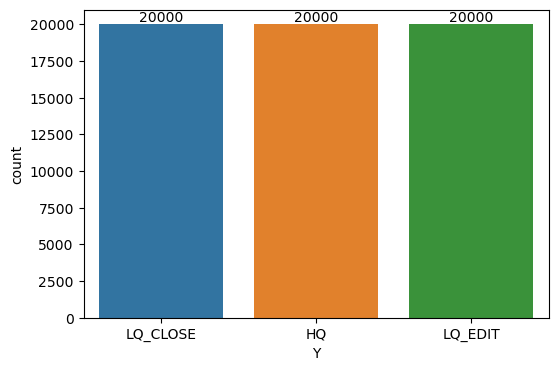

In [10]:
plt.subplots(figsize = (6,4))
ax = sns.countplot(data = data, x = 'Y')
ax.bar_label(ax.containers[0])

In [11]:
CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')

def clean_text(text):
    text = text.lower()
    # text = text.replace("[^a-zA-Z#]", " ")
    # text = text.replace('http\S+|www.\S+|.com\S+', ' ')
    text = re.sub(CLEANR, ' ', text)
    # text = re.sub("#+"," ", text)
    # text = re.sub("@[\w]*"," ", text)
    # text = re.sub("[^a-z\s]"," ", text)
    # text = re.sub("@[A-Za-z0-9_]+"," ", text)
    return text

def remove_duplicate_words(text):
    return re.sub(r'\b(\w+)(\s+\1)+\b', r'\1', text)

stopword_en = pd.read_csv('../../en_stopword_1555.txt', header=None).drop_duplicates()
en_stopword = stopword_en[0].values.tolist()
en_stopword = [word.strip() for word in en_stopword]

nltk_stopword = stopwords.words('english')

combined_stopwords = pd.DataFrame(en_stopword + nltk_stopword).drop_duplicates()
stopword_list = combined_stopwords[0].values.tolist()

In [30]:
# temp = data[data['clean_text'].str.contains('\r')]
# temp

In [12]:
data['clean_text'] = data['combined_text'] \
                    .progress_apply(clean_text) \
                    .progress_apply(lambda x: BeautifulSoup(x, 'html.parser').text) \
                    .progress_apply(lambda x: ' '.join([word for word in x.split() if word not in (nltk_stopword)]))
                    # .progress_apply(lambda x: ' '.join([word for word in x.split() if len(word) >= 4]))
                    # .progress_apply(remove_duplicate_words) \

data

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

C:\Users\indiz\AppData\Local\Temp\ipykernel_9184\2184689942.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  .progress_apply(lambda x: BeautifulSoup(x, 'html.parser').text) \


  0%|          | 0/60000 [00:00<?, ?it/s]

,Title,Body,Tags,Y,label,combined_text,clean_text
0,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,java repeat,LQ_CLOSE,2,Java: Repeat Task Every Random Seconds <p>I'm ...,java: repeat task every random seconds i'm alr...
1,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,java optional,HQ,0,Why are Java Optionals immutable? <p>I'd like ...,java optionals immutable? i'd like understand ...
2,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,javascript image overlay react-native opa...,HQ,0,Text Overlay Image with Darkened Opacity React...,text overlay image darkened opacity react nati...
3,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",swift operators whitespace ternary-operato...,HQ,0,Why ternary operator in swift is so picky? <p>...,"ternary operator swift picky? question simple,..."
4,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,android material-design floating-action-but...,HQ,0,hide/show fab with scale animation <p>I'm usin...,hide/show fab scale animation i'm using custom...
...,...,...,...,...,...,...,...
14995,How can I align two flex boxes to follow each ...,"<p>I have a menu, and I'd like the div.right-c...",html css flexbox,LQ_CLOSE,2,How can I align two flex boxes to follow each ...,"align two flex boxes follow other? menu, i'd l..."
14996,C++ The correct way to multiply an integer and...,<p>I try to multiply an integer by a double bu...,c++,LQ_CLOSE,2,C++ The correct way to multiply an integer and...,c++ correct way multiply integer double try mu...
14997,WHY DJANGO IS SHOWING ME THIS ERROR WHEN I TRY...,*URLS.PY*\r\n //URLS.PY FILE\r\n fro...,django django-views django-templates,LQ_EDIT,1,WHY DJANGO IS SHOWING ME THIS ERROR WHEN I TRY...,django showing error try open new page hyperli...
14998,PHP - getting the content of php page,<p>I have a controller inside which a server i...,javascript php html,LQ_CLOSE,2,PHP - getting the content of php page <p>I hav...,php - getting content php page controller insi...


In [12]:
# np.savetxt(r'clean_text.csv', data['clean_text'].values, fmt='%s')

<Axes: xlabel='text_len'>

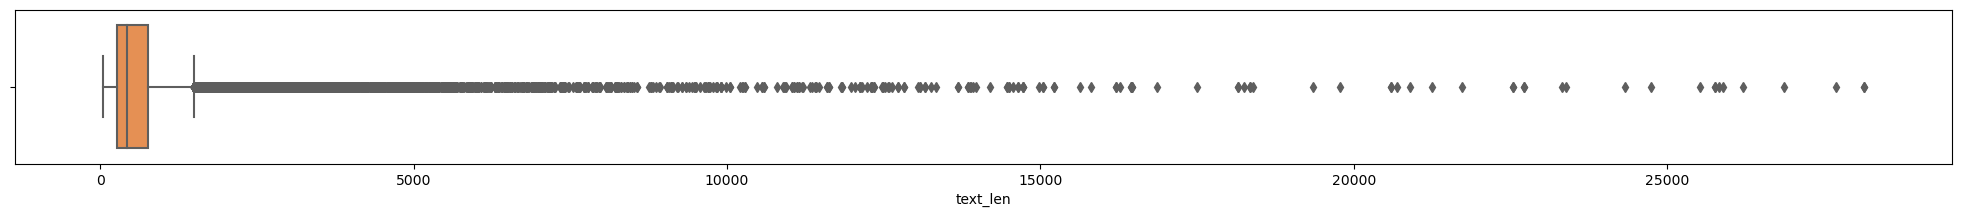

In [13]:
text_len = []

for idx, teks in enumerate(data['clean_text']):
    text_len.append(len(teks))
data['text_len'] = pd.DataFrame(text_len)

fig, axes = plt.subplots(figsize=(25, 2))
sns.boxplot(x=data['text_len'], palette="Oranges")

In [14]:
print(data['text_len'].quantile(0.25))
print(data['text_len'].quantile(0.75))

262.0
754.0


262.0
754.0


<Axes: xlabel='text_len'>

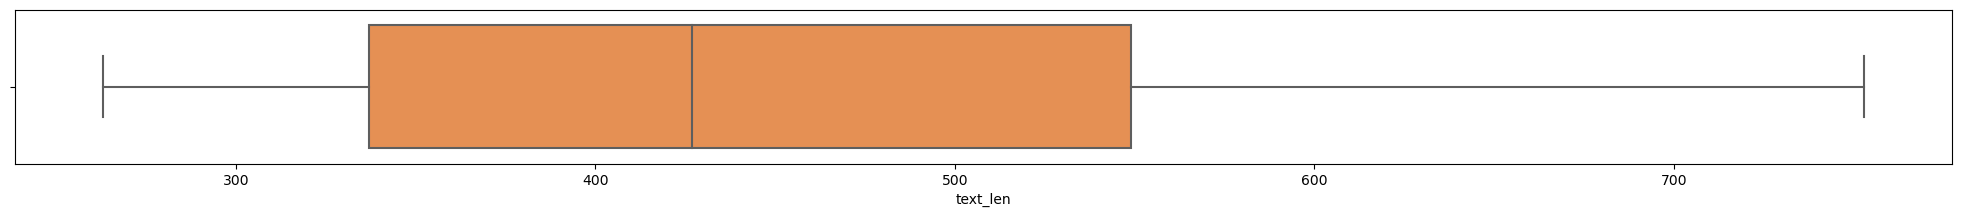

In [15]:
Q1 = data['text_len'].quantile(0.25)
Q3 = data['text_len'].quantile(0.75)

print(Q1)
print(Q3)

data = data[(data['text_len'] > Q1) & (data['text_len'] < Q3)]

fig, axes = plt.subplots(figsize=(25, 2))
sns.boxplot(x=data['text_len'], palette="Oranges")

[Text(0, 0, '9513'), Text(0, 0, '10173'), Text(0, 0, '10175')]

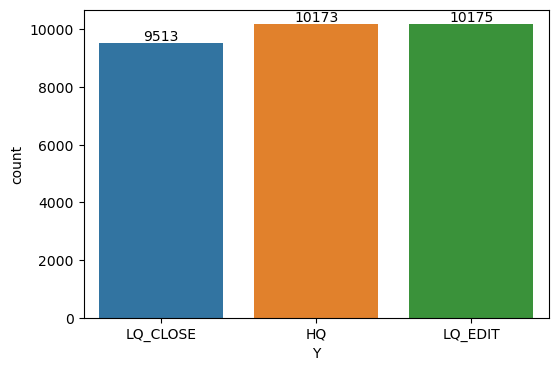

In [16]:
plt.subplots(figsize = (6,4))
ax = sns.countplot(data = data, x = 'Y')
ax.bar_label(ax.containers[0])

In [17]:
X = data['clean_text']
Y = to_categorical(data['label'])

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(20961,)
(5913,)
(2987,)


In [18]:
vocab_size = 10000
embedding_dim = 128
max_length = 755
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

In [19]:
# Tokenizing 
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)

print(len(tokenizer.word_index))

# Text to Sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)
validating_sequences = tokenizer.texts_to_sequences(X_val)

# Add padding
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = padding_type)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type)
validating_padded = pad_sequences(validating_sequences, maxlen = max_length, padding = padding_type)

# Convert to numpy array
training_padded = np.array(training_padded)
training_label = np.array(y_train)

testing_padded = np.array(testing_padded)
testing_label = np.array(y_test)

validating_padded = np.array(validating_padded)
validating_label = np.array(y_val)

99794


In [21]:
# initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.) ### 0.9
# initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=1.) ### 0.8004
# initializer = tf.keras.initializers.TruncatedNormal(mean=0., stddev=1.) ### 0.8842
# initializer = tf.keras.initializers.Zeros() ### 0.3400
# initializer = tf.keras.initializers.Ones()
# initializer = tf.keras.initializers.GlorotNormal() ### 0.8963
# initializer = tf.keras.initializers.GlorotUniform() ### 0.8916
# initializer = tf.keras.initializers.HeNormal() ### 0.9082
# initializer = tf.keras.initializers.HeUniform()
# initializer = tf.keras.initializers.Identity()
# initializer = tf.keras.initializers.Orthogonal()
# initializer = tf.keras.initializers.Constant(3.)
# initializer = tf.keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='uniform')

def CNN_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))

    model.add(Conv1D(128, 3, kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same', kernel_initializer = initializer))
    # model.add(LeakyReLU(0.2))
    model.add(ReLU())
    model.add(MaxPooling1D())
    model.add(Dropout(0.4))
    model.add(BatchNormalization())

    # model.add(Conv1D(512, 3, kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same', kernel_initializer = initializer))
    # # model.add(LeakyReLU(0.2))
    # model.add(ReLU())
    # model.add(MaxPooling1D())
    # model.add(Dropout(0.4))
    # model.add(BatchNormalization())

    model.add(Conv1D(128, 3, kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same', kernel_initializer = initializer))
    # model.add(LeakyReLU(0.2))
    model.add(ReLU())
    model.add(MaxPooling1D())
    model.add(Dropout(0.4))
    model.add(BatchNormalization())

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001), padding='same', kernel_initializer = initializer))
    # model.add(LeakyReLU(0.2))
    model.add(ReLU())
    model.add(MaxPooling1D())
    model.add(Dropout(0.4))
    model.add(BatchNormalization())

    # model.add(GlobalMaxPooling1D())
    model.add(Flatten())
    # model.add(Dense(4098, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))
    return model

def LSTM_Model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dense(32, activation='swish'))
    model.add(Dropout(0.2))
    # model.add(Dropout(0.5))
    # model.add(Dense(16, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    return model

def GRU_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(Bidirectional(GRU(64, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True)))
    model.add(Bidirectional(GRU(64, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True)))
    model.add(Dense(32, activation='swish'))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))
    return model

def CuDNNGRU_Model():
    sequences = layers.Input(shape=(max_length,))
    embedded = layers.Embedding(vocab_size, 64)(sequences)
    x = layers.CuDNNGRU(128, return_sequences=True)(embedded)
    x = layers.CuDNNGRU(128)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(100, activation='relu')(x)
    predictions = layers.Dense(3, activation='softmax')(x)
    model = models.Model(inputs=sequences, outputs=predictions)
    return model
    
def CNN_RNN_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))

    model.add(Bidirectional(GRU(128, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, reset_after=True, return_sequences=True , dropout=0.1 )))
    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001), padding='valid', kernel_initializer='glorot_uniform'))
    # model.add(LeakyReLU(0.2))
    model.add(ReLU())
    model.add(MaxPooling1D())
    model.add(Dropout(0.4))
    model.add(BatchNormalization())

    model.add(Flatten())
    # model.add(Dense(4098, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))
    return model


# model = CNN_Model()
# model = LSTM_Model()
model = GRU_Model()
# model = CuDNNGRU_Model()
# model = RNN_Model()
# model = CNN_RNN_Model()


model.summary()

# opt = RMSprop(learning_rate = 0.001)
# opt = SGD(learning_rate = 0.01)
opt = Adam(learning_rate = 0.001)

# model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
# model.compile(loss='mse', optimizer='sgd', metrics=['accuracy'])
# model.compile(loss='mse', optimizer='rmsprop', metrics=['accuracy'])

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=[tf.keras.metrics.AUC()])
# model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 755, 128)          1280000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 755, 128)         74496     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              74496     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                

In [22]:
num_epoch = 5
batch_size = 32

history = model.fit(training_padded, training_label, 
                    batch_size = batch_size, epochs = num_epoch, 
                    validation_data = (testing_padded, testing_label))

Epoch 1/5
656/656 [==============================] - 131s 192ms/step - loss: 0.8187 - accuracy: 0.6054 - val_loss: 0.7261 - val_accuracy: 0.6569
Epoch 2/5
656/656 [==============================] - 125s 191ms/step - loss: 0.6020 - accuracy: 0.7340 - val_loss: 0.7024 - val_accuracy: 0.6731
Epoch 3/5
656/656 [==============================] - 125s 190ms/step - loss: 0.4766 - accuracy: 0.8047 - val_loss: 0.7975 - val_accuracy: 0.6584
Epoch 4/5
656/656 [==============================] - 124s 188ms/step - loss: 0.3711 - accuracy: 0.8545 - val_loss: 0.8914 - val_accuracy: 0.6540
Epoch 5/5
656/656 [==============================] - 122s 186ms/step - loss: 0.2736 - accuracy: 0.9000 - val_loss: 1.1136 - val_accuracy: 0.6511


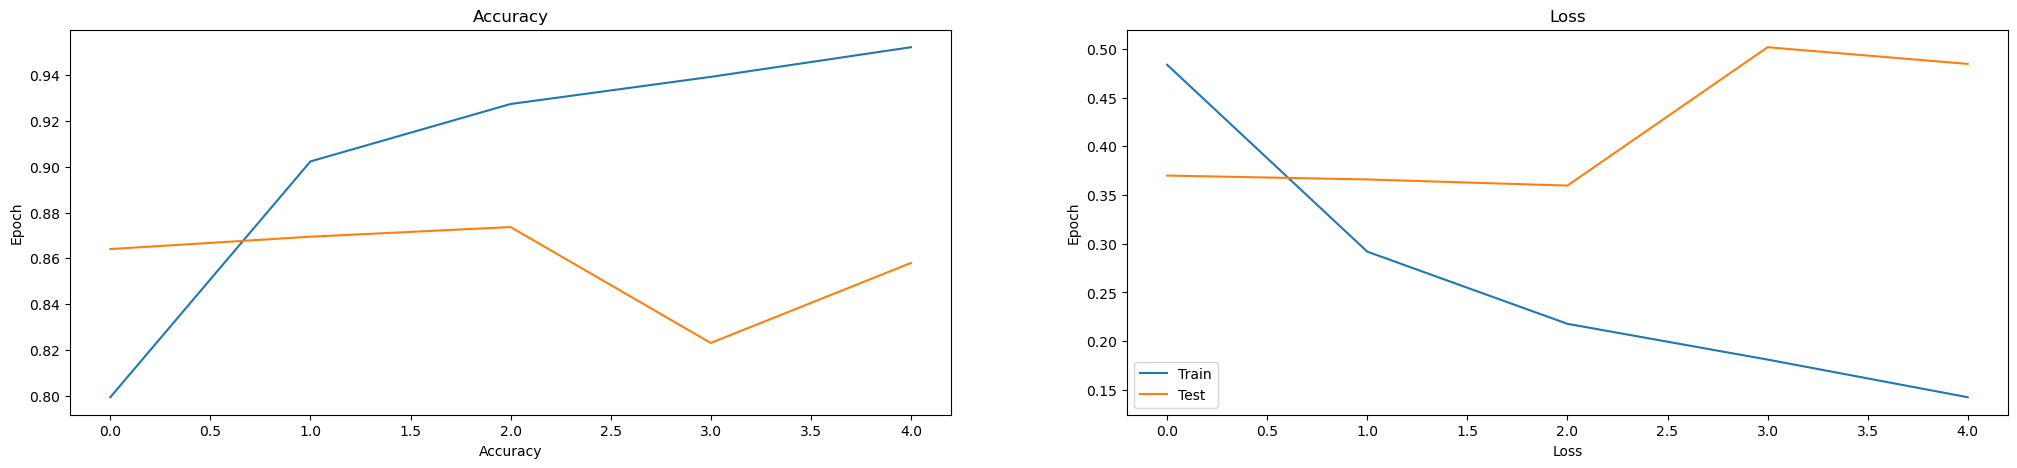

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25, 5))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('Epoch')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Loss')
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

In [110]:
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
# initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=1.)
# initializer = tf.keras.initializers.TruncatedNormal(mean=0., stddev=1.)
# initializer = tf.keras.initializers.Zeros()
# initializer = tf.keras.initializers.Ones()
# initializer = tf.keras.initializers.GlorotNormal()
# initializer = tf.keras.initializers.GlorotUniform()
# initializer = tf.keras.initializers.HeNormal()
# initializer = tf.keras.initializers.HeUniform()
# initializer = tf.keras.initializers.Identity()
# initializer = tf.keras.initializers.Orthogonal()
# initializer = tf.keras.initializers.Constant(3.)
# initializer = tf.keras.initializers.VarianceScaling(scale=0.1, mode='fan_in', distribution='uniform')

values = initializer(shape=(2, 2))
values

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[-2.1117063 , -0.47542506],
       [-0.46006864,  0.9523136 ]], dtype=float32)>

94/94 [==============================] - 17s 169ms/step


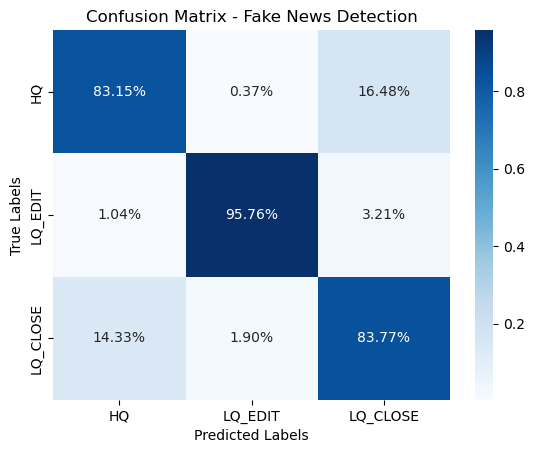

In [25]:
labels = ['HQ', 'LQ_EDIT', 'LQ_CLOSE']

y_pred = np.rint(model.predict(validating_padded))
# Build confusion matrix
con_mat = confusion_matrix(validating_label.argmax(axis=1),y_pred.argmax(axis=1))

# Compute the percentages for the confusion matrix
cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

# Create the heatmap using Seaborn
sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Add labels to the plot
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()

In [26]:
from sklearn.metrics import classification_report
print(classification_report(validating_label.argmax(axis=1),y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.86      0.83      0.85      1080
           1       0.98      0.96      0.97       966
           2       0.79      0.84      0.81       949

    accuracy                           0.87      2995
   macro avg       0.88      0.88      0.88      2995
weighted avg       0.88      0.87      0.87      2995



94/94 [==============================] - 16s 169ms/step


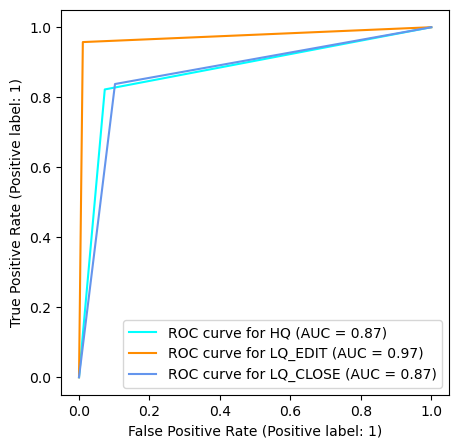

In [27]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

prob_test_vec = np.rint(model.predict(validating_padded))

n_classes = 3

fig, ax = plt.subplots(figsize=(5, 5))
target_names = ['HQ', 'LQ_EDIT', 'LQ_CLOSE']
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        validating_label[:, class_id],
        prob_test_vec[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )